* Segmentation de la page
* contours dans les segments
  * Aligment
  * Tracer des lignes entre les contours et traiter comme tableau classique

In [1]:
from PIL import Image as PILImage
from img2table.document import Image
from img2table.ocr import TesseractOCR
from img2table.tables.processing.common import get_contours_cell, is_contained_cell
from img2table.tables.processing.lines import detect_lines
from img2table.tables.objects.cell import Cell
from colordict import ColorDict
import cv2
import numpy as np

In [2]:
import random
colors = ColorDict()

def get_color():
    idx = random.randint(0, len(colors) - 1)
    return list(colors.values())[idx]

### Preprocessing

In [3]:
img = Image(r"C:\Users\xavca\Pictures\test_6.png")
ocr = TesseractOCR()
ocr_df = ocr.of(img)
dpi = 200

img = list(img.images)[0]

### Remove lines

In [4]:
h_lines, v_lines = detect_lines(image=img,
                                rho=0.3,
                                theta=np.pi / 180,
                                threshold=10,
                                minLinLength=dpi // 20,
                                maxLineGap=dpi // 20,
                                kernel_size=dpi // 10,
                                ocr_df=ocr_df)
lines = h_lines + v_lines

img_no_lines = img.copy()
for line in lines:
    cv2.rectangle(img_no_lines, (line.x1, line.y1), (line.x2, line.y2), (255, 255, 255), 5)

### Remove dark bg

In [5]:
blur = cv2.GaussianBlur(img_no_lines, (3, 3), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
dilation = cv2.dilate(thresh, (10, 10), iterations=3)
contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = Cell(x1=0, x2=0, y1=0, y2=0)
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    contour_cell = Cell(x, y, x + w, y + h)
    
    if contour_cell.width * contour_cell.height > largest_contour.width * largest_contour.height:
        largest_contour = contour_cell
        
# Recreate image
white_img = np.zeros(img.shape, dtype=np.uint8)
white_img.fill(255)

white_img[largest_contour.y1:largest_contour.y2, largest_contour.x1:largest_contour.x2] = img_no_lines[largest_contour.y1:largest_contour.y2, largest_contour.x1:largest_contour.x2]

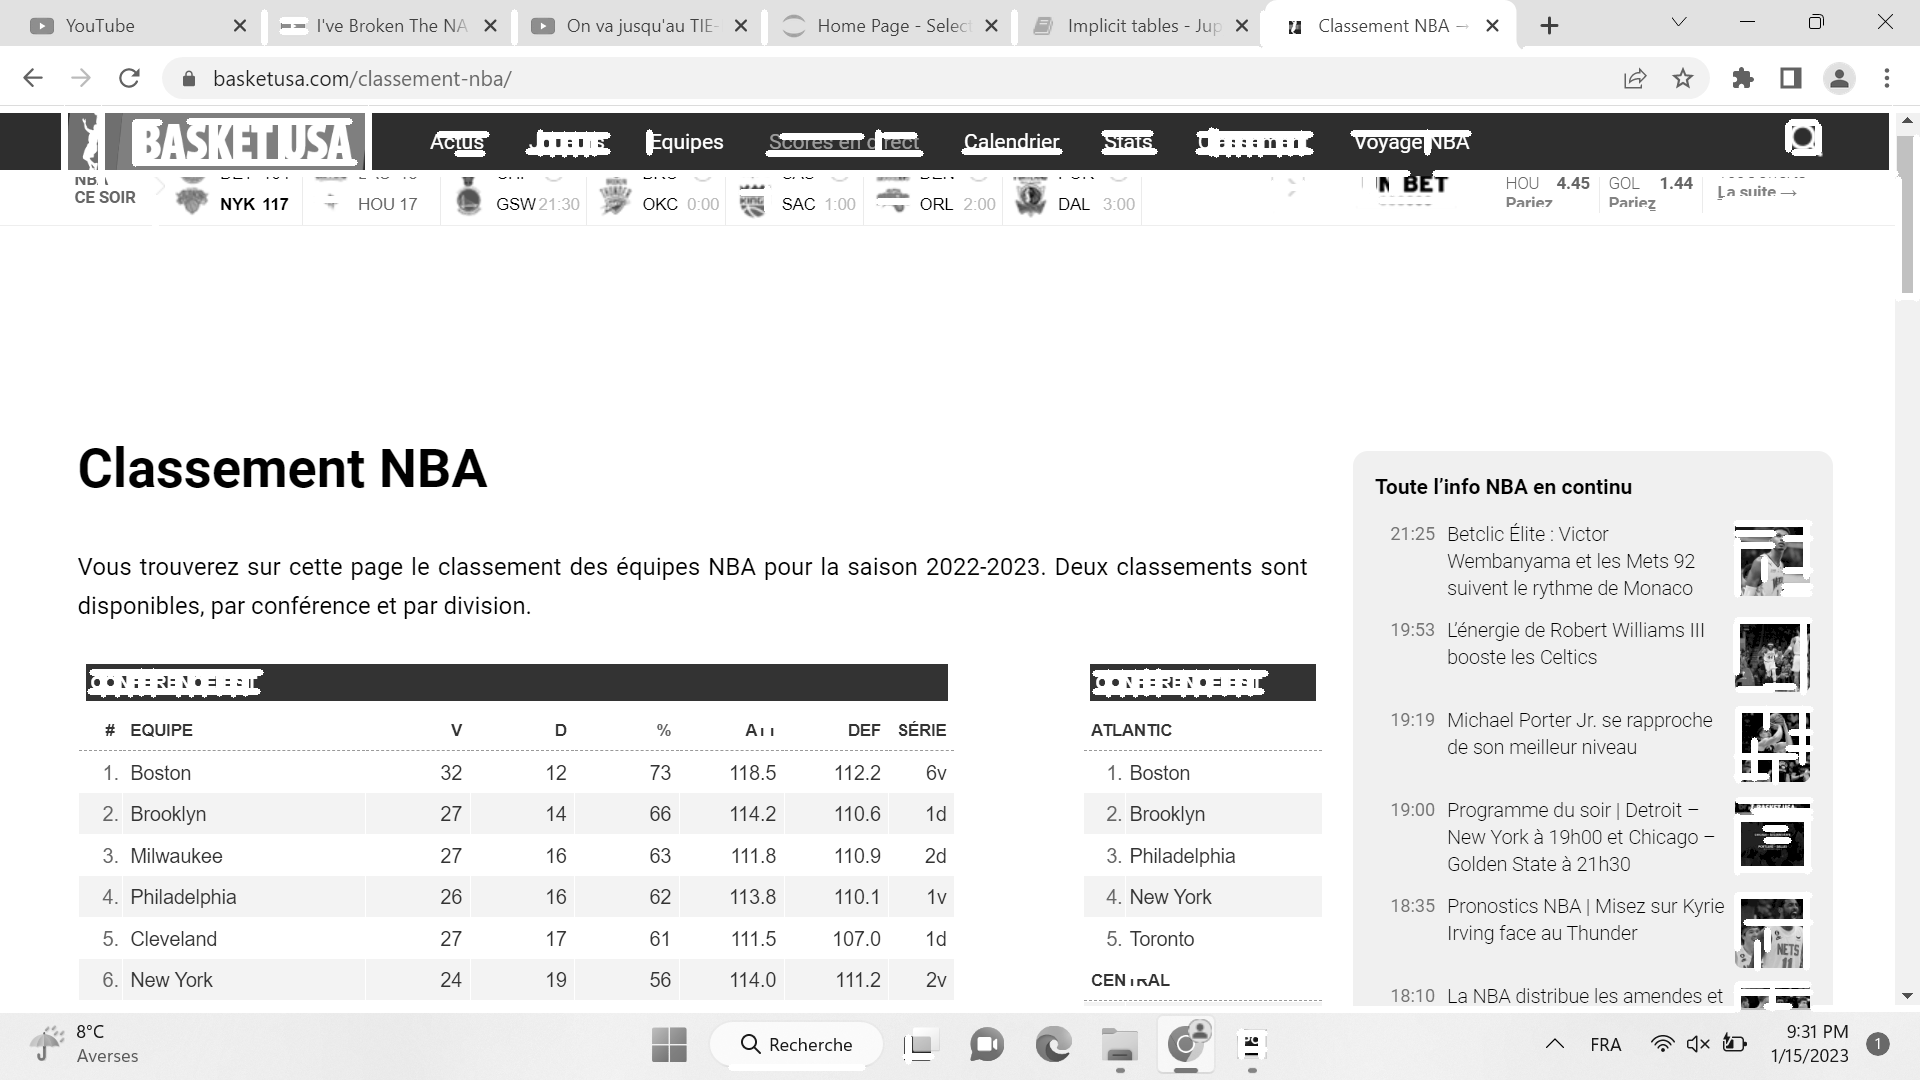

In [6]:
PILImage.fromarray(white_img)

### Image segmentation

In [7]:
img_segments = get_contours_cell(img=white_img.copy(),
                                 cell=Cell(x1=0, y1=0, x2=img.shape[1], y2=img.shape[0]),
                                 margin=0,
                                 blur_size=3,
                                 kernel_size=dpi // 10,
                                 merge_vertically=True)

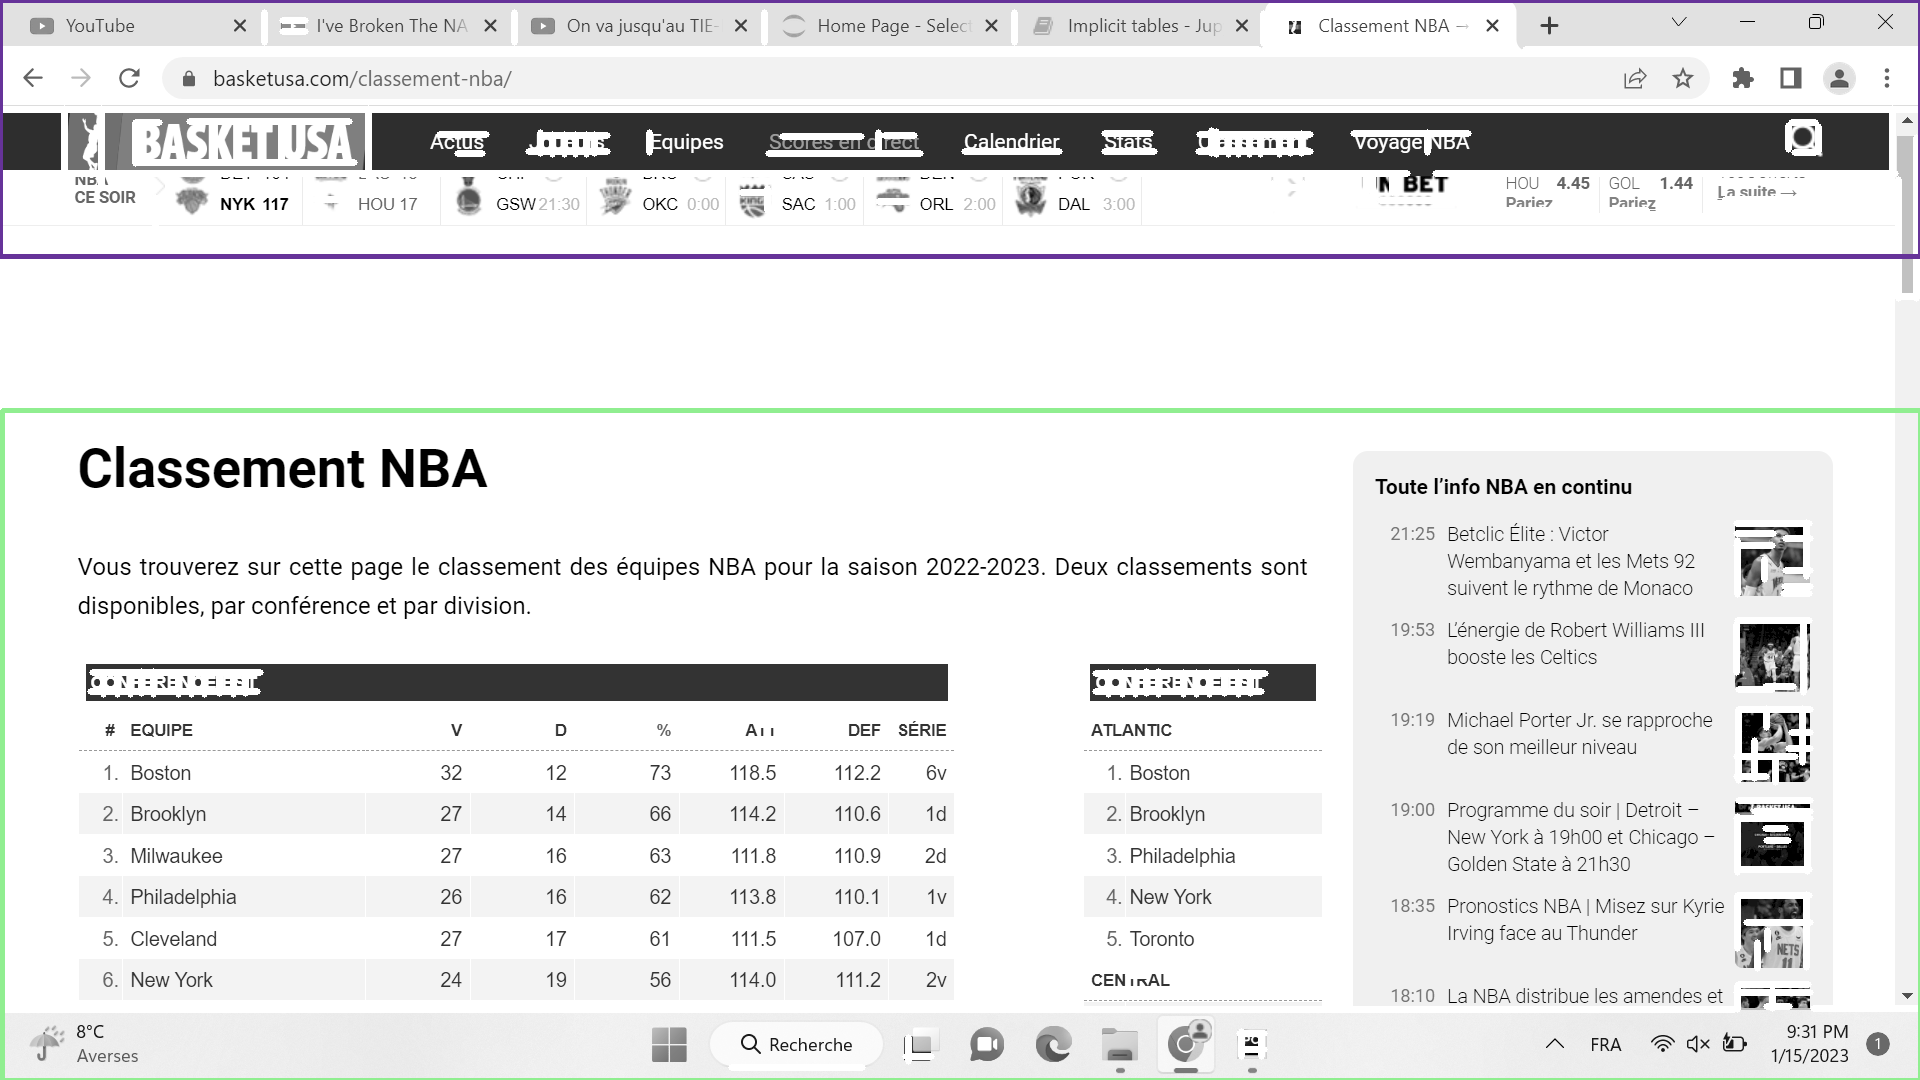

In [8]:
display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

for cnt in img_segments:
    cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

### Text segmentation

In [9]:
text_contours = get_contours_cell(img=white_img.copy(),
                                  cell=Cell(x1=0, y1=0, x2=img.shape[1], y2=img.shape[0]),
                                  margin=0,
                                  blur_size=3,
                                  kernel_size=dpi * 3 // 200,
                                  merge_vertically=None)

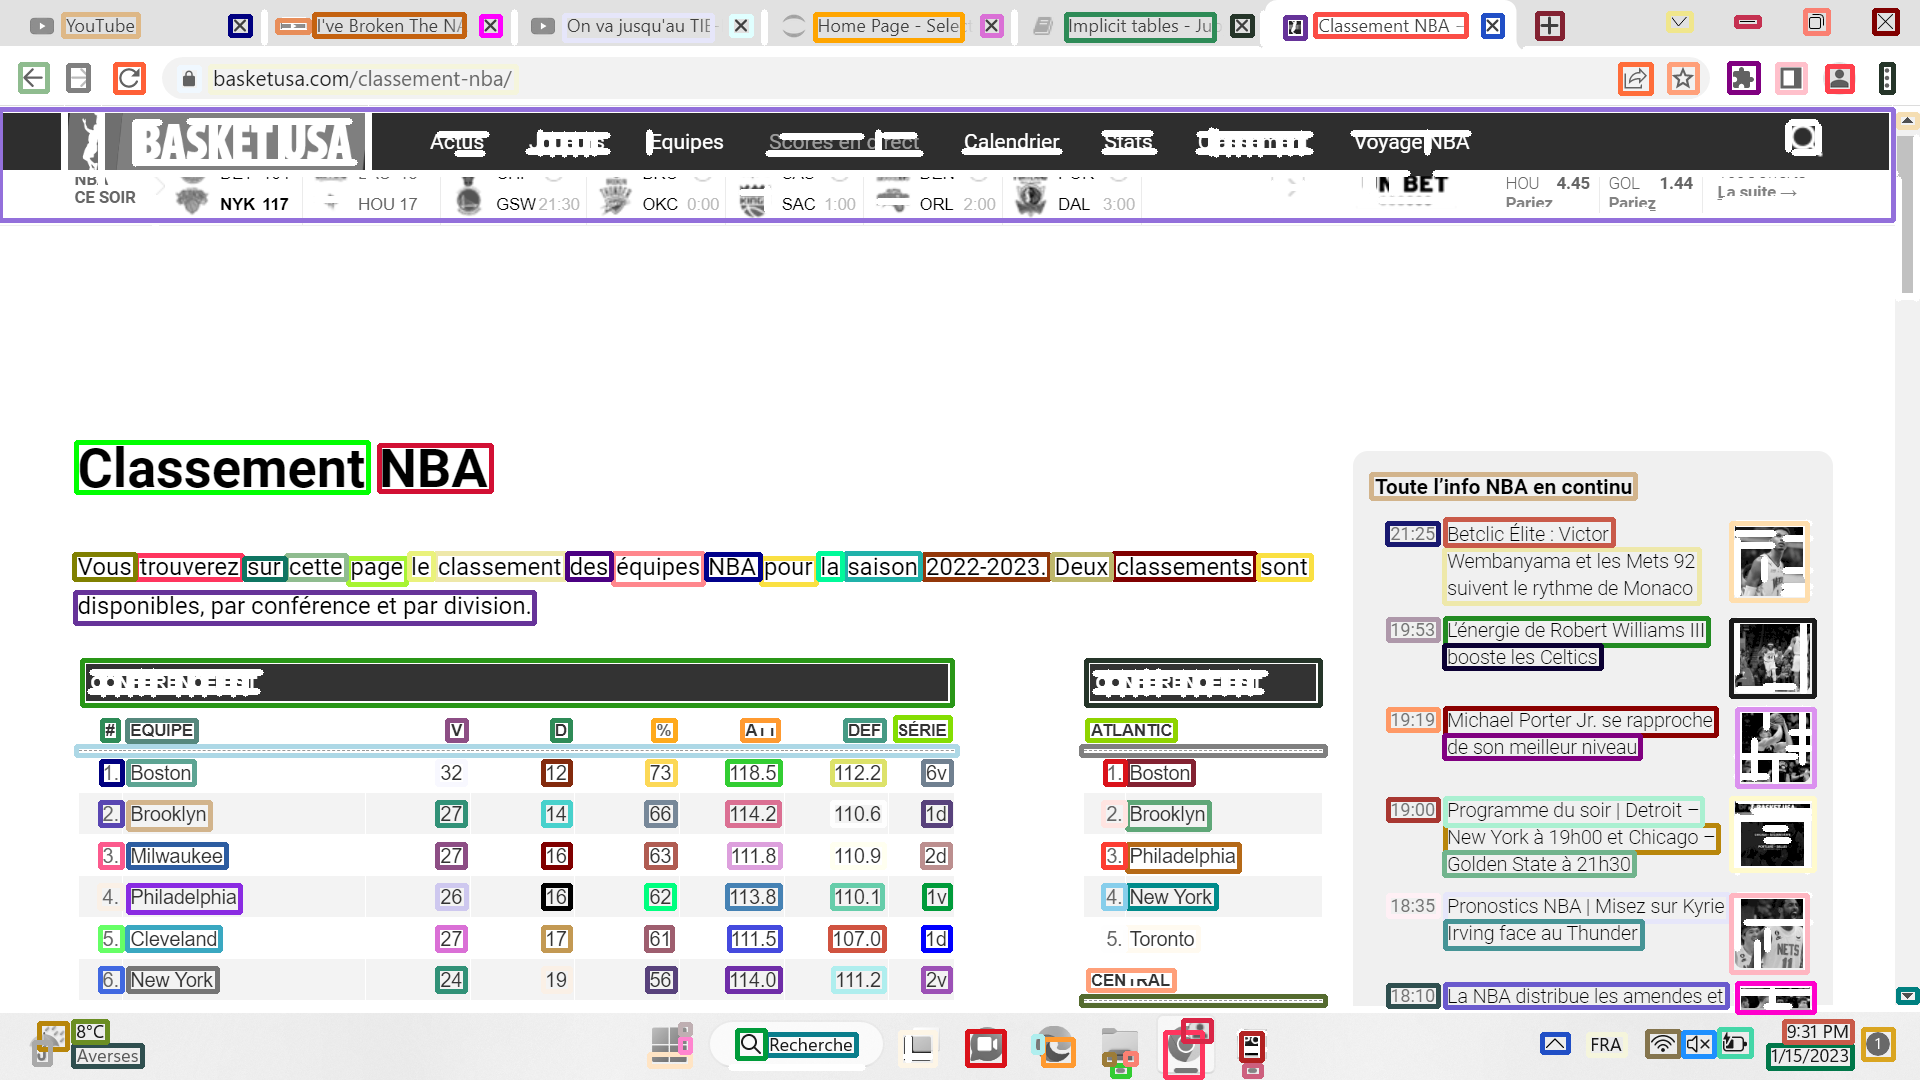

In [10]:
display_img = cv2.cvtColor(white_img.copy(), cv2.COLOR_GRAY2RGB)

for cnt in text_contours:
    cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

### Assign text contours to specific segments

In [11]:
dict_segments = {seg: [] for seg in img_segments}
for cnt in text_contours:
    # Find most likely segment
    best_segment = sorted([seg for seg in img_segments if is_contained_cell(inner_cell=cnt, outer_cell=seg)],
                          key=lambda s: s.width * s.height,
                          reverse=True).pop(0)
    dict_segments[best_segment].append(cnt)

In [12]:
dict_segments

{Cell(x1=0, y1=0, x2=1920, y2=256, content=None): [Cell(x1=0, y1=109, x2=1893, y2=220, content=None),
  Cell(x1=210, y1=66, x2=516, y2=92, content=None),
  Cell(x1=1066, y1=14, x2=1214, y2=40, content=None),
  Cell(x1=815, y1=14, x2=962, y2=40, content=None),
  Cell(x1=564, y1=15, x2=712, y2=40, content=None),
  Cell(x1=1315, y1=14, x2=1466, y2=36, content=None),
  Cell(x1=314, y1=14, x2=464, y2=36, content=None),
  Cell(x1=63, y1=14, x2=138, y2=36, content=None),
  Cell(x1=1620, y1=64, x2=1651, y2=93, content=None),
  Cell(x1=1729, y1=63, x2=1758, y2=92, content=None),
  Cell(x1=1777, y1=64, x2=1805, y2=92, content=None),
  Cell(x1=1669, y1=64, x2=1697, y2=92, content=None),
  Cell(x1=115, y1=64, x2=143, y2=92, content=None),
  Cell(x1=20, y1=64, x2=47, y2=91, content=None),
  Cell(x1=1827, y1=66, x2=1852, y2=91, content=None),
  Cell(x1=1537, y1=13, x2=1562, y2=38, content=None),
  Cell(x1=1874, y1=10, x2=1897, y2=33, content=None),
  Cell(x1=1805, y1=10, x2=1828, y2=33, content=None